In [207]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from sklearn.metrics import roc_curve
import torch
from torch.autograd import Variable
matplotlib.rcParams.update({'font.size': 18})

In [89]:
protected_var = 'sex'
if protected_var == 'sex':
  protected_var_categories = ['Male', 'Female']
elif protected_var == 'race':
  protected_var_categories = ['White', 'Black', 'Asian', 'American-Indian', 'Other']
elif protected_var == 'age':
  protected_var_categories = ['0-18', '18-25', '25-30', '30-35', '35-40', '40-45', '45-50',
                              '50-55', '55-60', '60-65', '65+']

In [90]:
# Data paths
path = 'data/adult/'
X_name = path + 'X_valid.pkl' # CHANGE TO VAL
y_name = path + 'y_valid.pkl'
z_name = path + protected_var + '_valid.pkl'

In [91]:
# Load data
def load_data(fname):
  data = pd.read_pickle(fname)
  return data.values, Variable(torch.tensor(data.values).float())

X, X_tensor = load_data(X_name)
y, y_tensor = load_data(y_name)
z, z_tensor = load_data(z_name)

In [227]:
# Model paths
path = 'logs/adult/'
alpha_names = []
# alphas = ['0.1', '0.5', '1', '1.5', '2.5', '5', '7.5', '10']
alphas = ['1', '900']
for alpha in alphas:
  alpha_names.append(path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_' \
    + alpha + '-model.pth')
  
basic_model_name = path + 'basic-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10--dropout_rate_0.5--model.pth'
odds_model_name = path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_10-model.pth'
parity_model_name = path + protected_var + '-parity-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_10-model.pth'

In [228]:
# Load models
def load_model(fname):
  model = torch.load(fname)
  model.eval()
  return model

basic_model = load_model(basic_model_name)
odds_model = load_model(odds_model_name)
parity_model = load_model(parity_model_name)
alpha_models = {}
for i, alpha in enumerate(alphas):
  alpha_models[alpha] = load_model(alpha_names[i])

/Users/justinchen/miniconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [229]:
basic_yhat = basic_model(X_tensor).data.numpy().squeeze()
odds_yhat = odds_model(X_tensor).data.numpy().squeeze()
parity_yhat = parity_model(X_tensor).data.numpy().squeeze()

In [230]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# ROC plots

In [231]:
def get_roc(yhat):
  curves = []
  for i in range(len(protected_var_categories)):
    curves.append(roc_curve(y[z == i], yhat[z == i]))
  return curves
  
basic_roc = get_roc(basic_yhat)
odds_roc = get_roc(odds_yhat)
parity_roc = get_roc(parity_yhat)
# alpha_rocs = {}
# for alpha in alpha_models:
#   alpha_rocs[alpha] = get_roc(alpha_models[alpha])

In [232]:
colors = ['teal', 'lightcoral']
colors2 = ['darkblue', 'darkred']

def plot_roc(curves, ax, model_type, xrange=None, yrange=None):
  for i, curve in enumerate(curves):
    fpr, tpr, thresholds = curve
    idx_thresh = find_nearest(thresholds, .5)
    ax.scatter(fpr[idx_thresh], tpr[idx_thresh], marker='x', s=400, c=colors2[i], linewidth=4)
    ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
           c=colors[i], linewidth=3)
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.legend(loc=2)
  if xrange is not None:
    ax.set_xlim(xrange[0], xrange[1])
  if yrange is not None:
    ax.set_ylim(yrange[0], yrange[1])

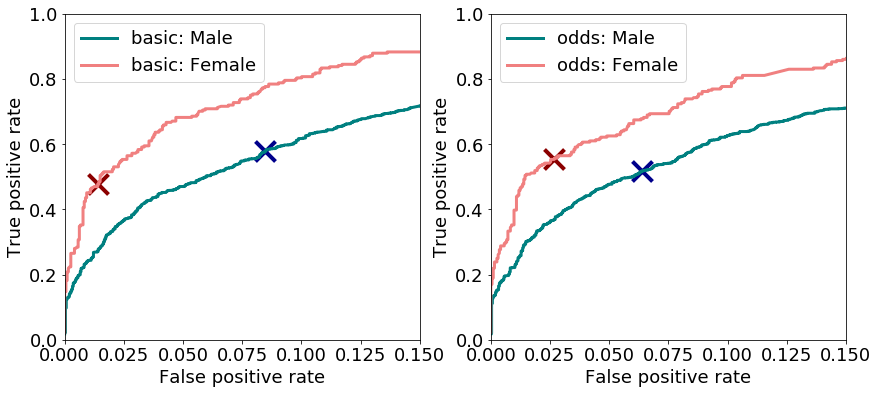

In [237]:
xrange = [0, 0.15]
yrange = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(14,6))
# Plot 1
def plot_compare(roc, idx, name):
  plot_roc(roc, axes[idx], name, xrange=xrange, yrange=yrange)
  
plot_compare(basic_roc, 0, 'basic')
plot_compare(odds_roc, 1, 'odds')

# Equal opportunity: threshold

In [226]:
def predict_by_sex(yhat, male_thresh, female_thresh):
  ypred = np.zeros_like(yhat).astype(bool)
  ypred[z == 0] = (yhat[z == 0] > male_thresh)
  ypred[z == 1] = (yhat[z == 1] > female_thresh)
  return ypred

def get_acc_from_threshold(yhat, y, male_thresh, female_thresh):
  return np.sum([predict_by_sex(yhat, male_thresh, female_thresh) == y]) / y.shape[0]

print(get_acc_from_threshold(basic_yhat, y, 0.5, 0.5))

0.8530631045601106


In [257]:
def get_opportunity_ids(male_roc, female_roc):
  male_fpr, male_tpr, male_threshs = male_roc
  female_fpr, female_tpr, female_threshs = female_roc
  female_ids = np.zeros((male_fpr.shape[0],)).astype(int) # female_id by male_id for opportunity
  for i, tpr in enumerate(male_tpr):
    female_ids[i] = find_nearest(female_tpr, tpr)
  return female_ids

basic_female_ids = get_opportunity_ids(basic_roc[0], basic_roc[1])
odds_female_ids = get_opportunity_ids(odds_roc[0], odds_roc[1])

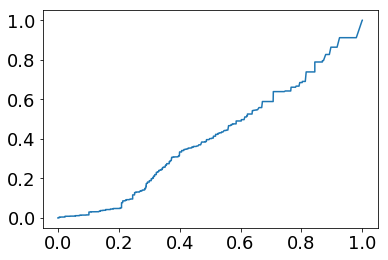

In [282]:
male_fpr, male_tpr, male_threshs = basic_roc[0]
female_fpr, female_tpr, female_threshs = basic_roc[1]
plt.plot(male_threshs, female_threshs[basic_female_ids])

In [263]:
def get_opportunity_accuracies(yhat, male_roc, female_roc, female_ids):
  male_fpr, male_tpr, male_threshs = male_roc
  female_fpr, female_tpr, female_threshs = female_roc
  accuracies = np.zeros_like(male_threshs)
  for i, male_thresh in enumerate(male_threshs):
    female_thresh = female_threshs[female_ids[i]]
    accuracies[i] = get_acc_from_threshold(yhat, y, male_thresh, female_thresh)
  return accuracies

basic_opp_acc = get_opportunity_accuracies(basic_yhat, basic_roc[0], basic_roc[1], basic_female_ids)
odds_opp_acc = get_opportunity_accuracies(odds_yhat, odds_roc[0], odds_roc[1], odds_female_ids)

[0.7653923  0.76953787 0.7696914  ... 0.286811   0.28665745 0.28466144]


In [307]:
def plot_threshold(male_roc, female_roc, female_ids, accuracies, ax, name):
  ax2 = ax.twinx()
  male_fpr, male_tpr, male_threshs = male_roc
  female_fpr, female_tpr, female_threshs = female_roc
  tp_gap = np.abs(male_tpr - female_tpr[female_ids])

  c1 = 'navy'
  ax.plot(male_threshs, accuracies, c=c1, label=name+': accuracy')
  ax.tick_params('y', colors=c1)
  plt.yscale('log')
  ax.set_xlabel('Threshold for male logits')
  ax.set_ylabel('Accuracy', color=c1)
  
  c2 = 'firebrick' 
  ax2.plot(male_threshs, tp_gap, c=c2, label=name+': TP-gap')
  ax2.tick_params('y', colors=c2)
  ax2.set_ylabel('TP-gap', color=c2)

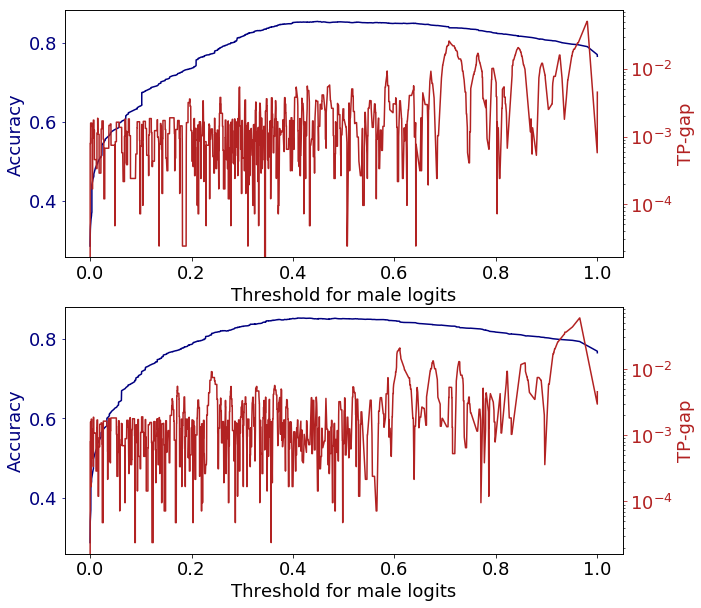

In [308]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))
plot_threshold(basic_roc[0], basic_roc[1], basic_female_ids, basic_opp_acc, axes[0], 'basic')
plot_threshold(odds_roc[0], odds_roc[1], odds_female_ids, odds_opp_acc, axes[1], 'odds')

# Equal opportunity: Acc vs. TP gap